## Cálculos de BAD e OVER

### BAD Rate
BAD Rate = (Número de Empréstimos Incobráveis / Total de Empréstimos Aprovados) x 100%

Definição: É a taxa de inadimplência, ou seja, a proporção de empréstimos que se tornaram incobráveis (default) em relação ao total de empréstimos concedidos.

Importância: Entender o risco de crédito da carteira. Uma taxa de BAD alta indica que uma proporção significativa dos empréstimos concedidos não está sendo paga conforme o esperado.

### OVER
OVER = Σ (Valor dos Empréstimos Incobráveis)

Definição: Geralmente refere-se ao valor total dos empréstimos que se tornaram incobráveis. Representa o impacto financeiro absoluto da inadimplência.

Importância: Quantificar o prejuízo financeiro direto causado pelos empréstimos que não foram pagos. É um indicador do montante total de dinheiro perdido devido a inadimplências.

# Análise de Aprovação de Empréstimo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

C:\Users\natasha.fonseca\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [1]:
loan_data = pd.read_csv('loan_data_cleaned.csv')
loan_data.head()

C:\Users\natasha.fonseca\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,record_id,issue_d,loan_amnt,term,int_rate,installment,score,loan_status,total_pymnt,last_pymnt_d,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,Aug-2015,15000,36,14.65,517.42,0.219093,Charged Off,13484.010000,Nov-2017,...,0,0,0,0,0,0,0,0,0,0
1,1,Oct-2015,10000,36,5.32,301.15,0.067309,Fully Paid,10833.924836,Oct-2018,...,0,0,0,0,0,0,0,0,0,0
2,2,Jan-2014,24000,36,7.62,747.88,0.015098,Fully Paid,25184.850003,Oct-2014,...,0,0,0,0,0,0,0,0,0,0
3,3,Sep-2015,9600,36,13.99,328.06,0.167956,Fully Paid,11824.009057,Oct-2018,...,0,0,0,0,0,0,0,0,0,0
4,4,Sep-2015,8000,36,12.29,266.83,0.233873,Fully Paid,9591.786147,Sep-2018,...,0,0,0,0,0,1,0,0,0,0


In [9]:
# Calcular estatísticas descritivas
summary_stats = loan_data.describe()
summary_stats.head()

,record_id,loan_amnt,term,int_rate,installment,score,total_pymnt,emp_length,annual_inc,dti,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,installment_to_income_ratio,payment_to_loan_amount_ratio
count,44543.000000,44543.000000,44543.0,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,...,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000,44543.000000
mean,22285.270233,12703.245740,36.0,11.733649,419.161214,0.164574,13653.202284,6.221572,73728.062589,18.111633,...,0.018611,0.012235,0.007364,0.053566,0.000853,0.009564,0.007207,0.000090,0.006517,1.074999
std,12868.468511,7986.016552,0.0,3.819018,264.741351,0.093536,9218.742231,3.638239,52640.652776,8.448037,...,0.135149,0.109936,0.085496,0.225162,0.029196,0.097327,0.084586,0.009476,0.003621,0.219227
min,0.000000,1000.000000,36.0,5.320000,30.880000,0.000000,0.000000,0.500000,4000.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000
25%,11140.500000,6725.000000,36.0,8.380000,220.620000,0.090000,6752.612447,3.000000,44000.000000,11.670000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003700,1.075169


## Conversão e limpeza dos dados

In [41]:
warnings.simplefilter(action='ignore', category=FutureWarning)

missing_values = loan_data.isnull().sum()
data_types = loan_data.dtypes


# Vamos separar colunas numéricas e categóricas, e preencheremos os valores ausentes numéricos com a média e os valores categóricos com a moda
numeric_cols = loan_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = loan_data.select_dtypes(include=['object']).columns


loan_data[numeric_cols] = loan_data[numeric_cols].fillna(loan_data[numeric_cols].mean())
loan_data[categorical_cols] = loan_data[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

missing_values_after = loan_data.isnull().sum()
print(missing_values_after)
loan_data.head()


record_id                   0
issue_d                     0
loan_amnt                   0
term                        0
int_rate                    0
                           ..
purpose_other               0
purpose_renewable_energy    0
purpose_small_business      0
purpose_vacation            0
purpose_wedding             0
Length: 86, dtype: int64


,record_id,issue_d,loan_amnt,term,int_rate,installment,score,loan_status,total_pymnt,last_pymnt_d,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,Aug-2015,15000,36,14.65,517.42,0.219093,Charged Off,13484.010000,Nov-2017,...,0,0,0,0,0,0,0,0,0,0
1,1,Oct-2015,10000,36,5.32,301.15,0.067309,Fully Paid,10833.924836,Oct-2018,...,0,0,0,0,0,0,0,0,0,0
2,2,Jan-2014,24000,36,7.62,747.88,0.015098,Fully Paid,25184.850003,Oct-2014,...,0,0,0,0,0,0,0,0,0,0
3,3,Sep-2015,9600,36,13.99,328.06,0.167956,Fully Paid,11824.009057,Oct-2018,...,0,0,0,0,0,0,0,0,0,0
4,4,Sep-2015,8000,36,12.29,266.83,0.233873,Fully Paid,9591.786147,Sep-2018,...,0,0,0,0,0,1,0,0,0,0


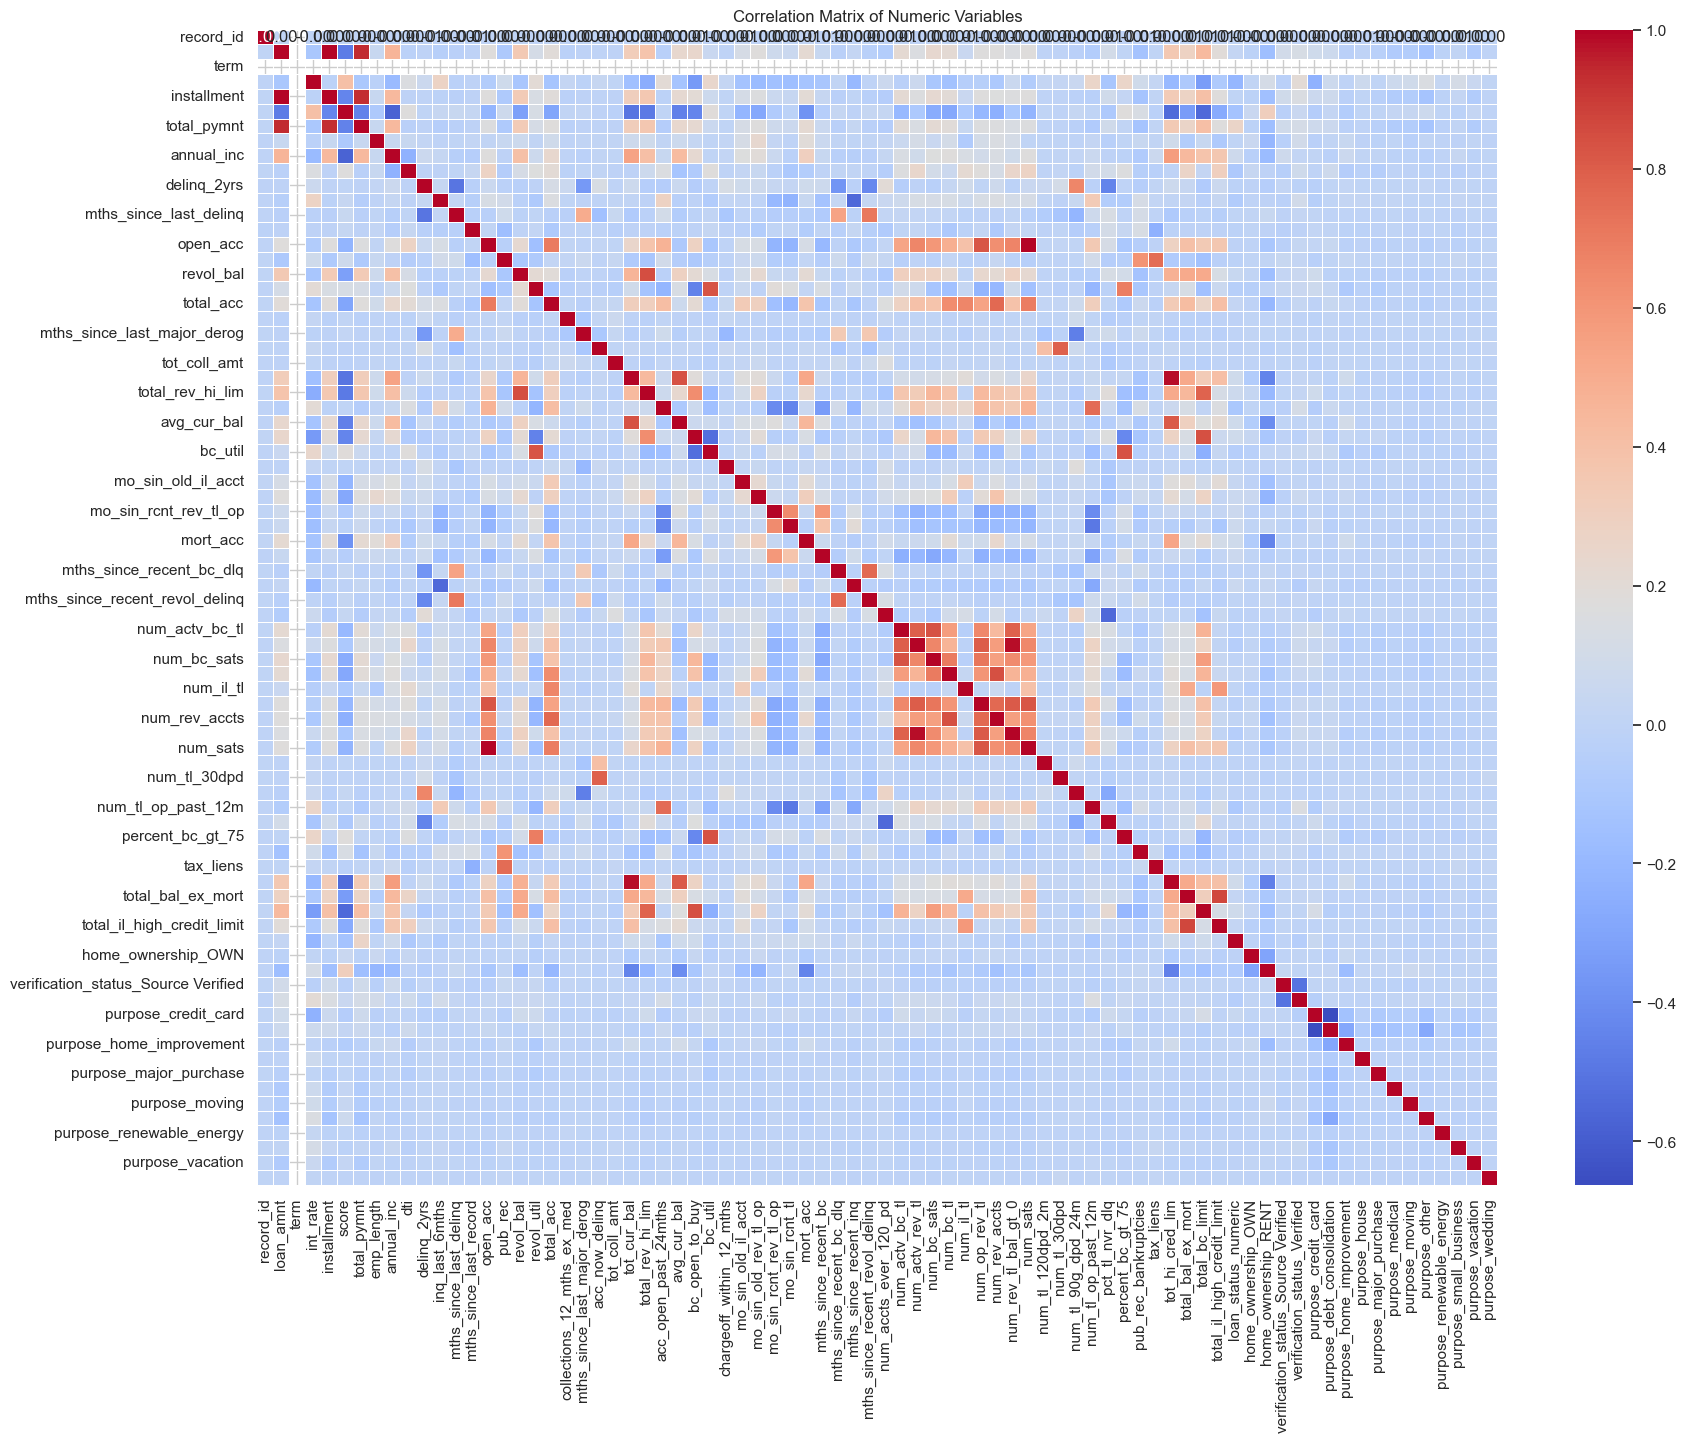

loan_status_numeric     1.000000
total_pymnt             0.260406
tot_hi_cred_lim         0.087686
total_bc_limit          0.083832
mort_acc                0.081976
                          ...   
num_tl_op_past_12m     -0.092650
acc_open_past_24mths   -0.100028
score                  -0.132067
int_rate               -0.207438
term                         NaN
Name: loan_status_numeric, Length: 78, dtype: float64


In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    # Código que gera o aviso
    plt.figure(figsize=(20, 15))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title('Correlation Matrix of Numeric Variables')
    plt.show()
    
correlation_with_loan_status = correlation_matrix['loan_status_numeric'].sort_values(ascending=False)
print(correlation_with_loan_status)

## Análise de Dados Exploratória (EDA)

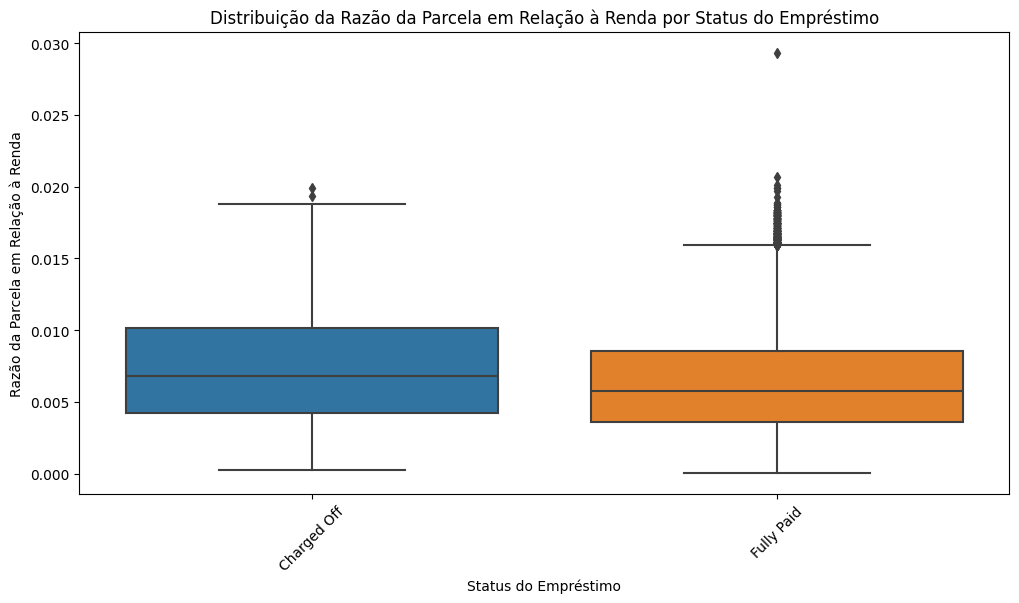

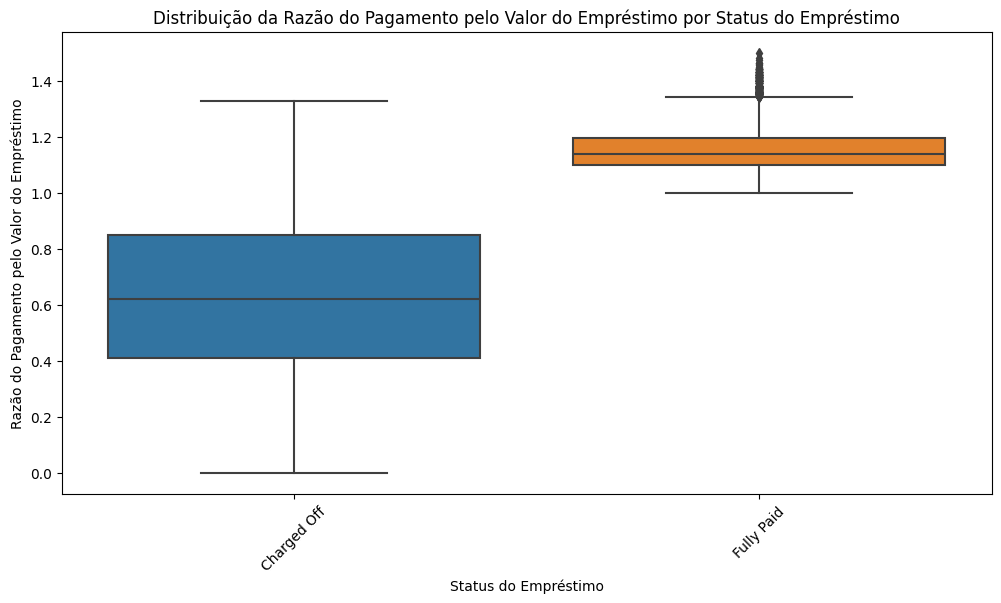

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='installment_to_income_ratio', data=loan_data)
plt.title('Distribuição da Razão da Parcela em Relação à Renda por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Razão da Parcela em Relação à Renda')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='payment_to_loan_amount_ratio', data=loan_data)
plt.title('Distribuição da Razão do Pagamento pelo Valor do Empréstimo por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Razão do Pagamento pelo Valor do Empréstimo')
plt.xticks(rotation=45)
plt.show()



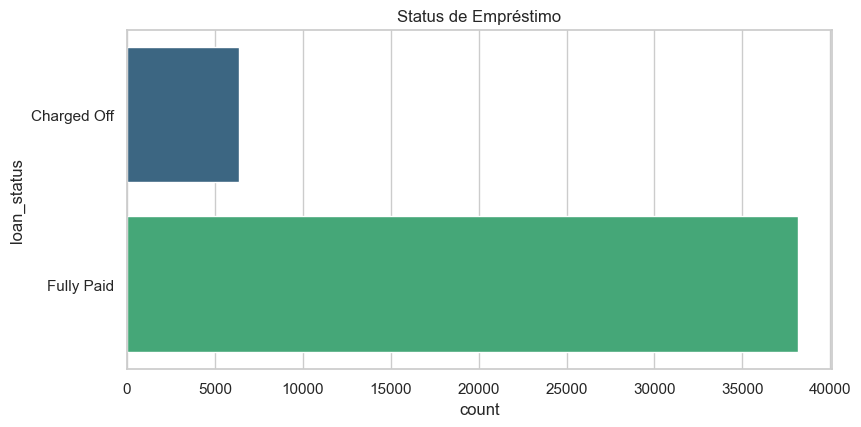

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 2, 5)
    sns.countplot(y=loan_data['loan_status'], palette='viridis')
    plt.title('Status de Empréstimo')
    plt.show()

#### Distribuição do Status do Empréstimo (`loan_status`)
- **Qualidade da Carteira de Empréstimos**: Mostra a proporção de empréstimos que foram totalmente pagos, estão em atraso ou foram inadimplentes.
- **Eficiência de Cobrança**: Pode indicar a eficiência das políticas de cobrança e a saúde geral da carteira de empréstimos.
- **Taxa de Inadimplência**: Uma alta proporção de empréstimos inadimplentes pode indicar problemas na avaliação de crédito ou na gestão de riscos.

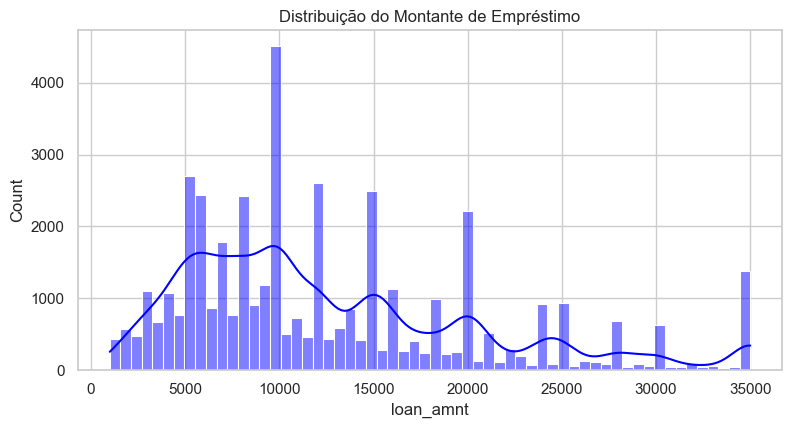

In [26]:
loan_data.replace([np.inf, -np.inf], np.nan, inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 2, 1)
    sns.histplot(loan_data['loan_amnt'], kde=True, color='blue')
    plt.title('Distribuição do Montante de Empréstimo')
    plt.show()

#### 1. Distribuição do Montante do Empréstimo (`loan_amnt`)
- **Forma da Distribuição**: A distribuição do montante do empréstimo pode mostrar se os valores dos empréstimos estão concentrados em uma faixa específica (por exemplo, pequenos, médios ou grandes empréstimos).
- **Assimetria**: Se a distribuição for assimétrica, podemos inferir que há uma prevalência de empréstimos de valor menor ou maior.
- **Picos e Caudas**: Picos na distribuição indicam faixas de valores mais comuns, enquanto caudas longas podem indicar a presença de empréstimos de valor excepcionalmente alto ou baixo.

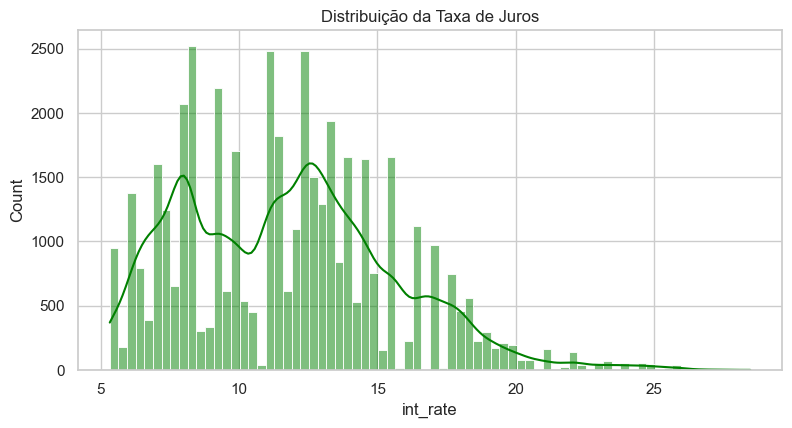

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 2, 2)
    sns.histplot(loan_data['int_rate'], kde=True, color='green')
    plt.title('Distribuição da Taxa de Juros')
    plt.show()

#### 2. Distribuição da Taxa de Juros (`int_rate`)
- **Faixa de Taxas de Juros**: Mostra a faixa de taxas de juros aplicadas aos empréstimos e a concentração de empréstimos em diferentes taxas.
- **Padrões de Risco**: Altas taxas de juros podem estar associadas a empréstimos de maior risco, enquanto baixas taxas podem indicar empréstimos de menor risco. Empréstimos para pessoas de maior risco tendem a ter taxas de juros maiores, para garantir que a pessoa pague a maior parcela possível antes de deixar de pagar (over, ou montante não pago).
- **Política de Empréstimos**: Pode indicar a política de precificação de riscos do credor, onde certos valores de taxa de juros são mais comuns.

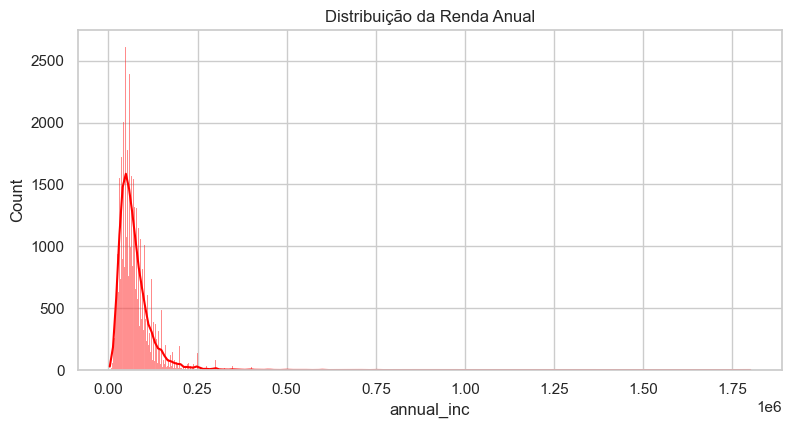

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 2, 3)
    sns.histplot(loan_data['annual_inc'], kde=True, color='red')
    plt.title('Distribuição da Renda Anual')
    plt.show()

#### 3. Distribuição da Renda Anual (`annual_inc`)
- **Distribuição de Renda**: Mostra a distribuição de renda anual dos clientes, indicando se a maioria dos clientes está em faixas de renda mais baixas, médias ou altas.
- **Perfil dos Clientes**: Pode ajudar a entender o perfil econômico dos clientes e se a instituição está servindo principalmente a indivíduos de baixa, média ou alta renda.
- **Análise de Risco**: Rendas mais altas geralmente estão associadas a menor risco de inadimplência, enquanto rendas mais baixas podem indicar maior risco.

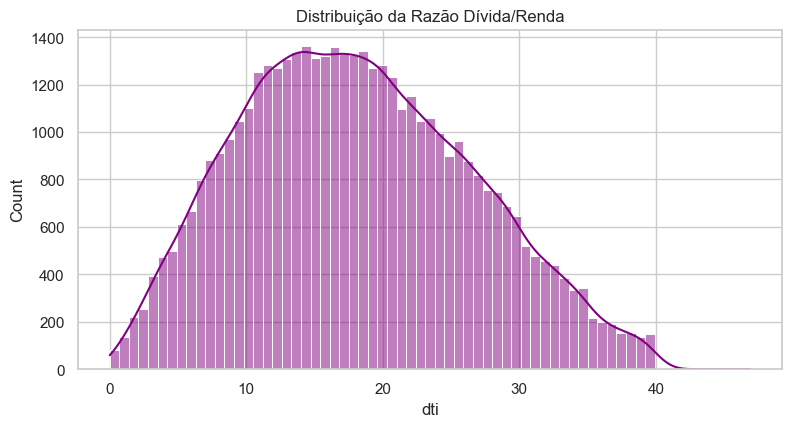

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 2, 4)
    sns.histplot(loan_data['dti'], kde=True, color='purple')
    plt.title('Distribuição da Razão Dívida/Renda')
    plt.show()

#### 4. Distribuição da Razão Dívida/Renda (`dti`)
- **Níveis de Endividamento**: Mostra como os níveis de endividamento dos clientes variam em relação à sua renda.
- **Capacidade de Pagamento**: Altos valores de DTI indicam que uma grande parte da renda do cliente está comprometida com dívidas, o que pode ser um indicador de maior risco de inadimplência.
- **Perfil de Risco**: Identifica grupos de clientes com diferentes perfis de risco baseado em suas razões dívida/renda.

### Resumo e Implicações: avaliação do risco de inadimplência e na determinação das condições de empréstimo.

- **Pagamentos e Limites de Crédito**: Variáveis como `total_pymnt`, `tot_hi_cred_lim` e `total_bc_limit` têm correlação positiva com `loan_status_numeric`, indicando que pagamentos maiores e limites de crédito mais altos estão associados a empréstimos que são totalmente pagos.

- **Linhas de Crédito Recentes e Scores de Crédito**: Variáveis (behaviour) como `num_tl_op_past_12m`, `acc_open_past_24mths` e `score` têm correlação negativa, sugerindo que a abertura de novas linhas de crédito e scores de crédito mais baixos estão associados a uma menor probabilidade de pagamento total.

- **Taxa de Juros**: A taxa de juros (`int_rate`) tem uma correlação negativa significativa com `loan_status_numeric`, sugerindo que empréstimos com taxas de juros mais altas têm menor probabilidade de serem totalmente pagos.


relacionadas ao charged off

## Comparação de análise de critérios em novos aplicantes

In [3]:
file_path = 'loan_data_cleaned.csv'
loan_data = pd.read_csv(file_path)

loan_data.head()

,record_id,issue_d,loan_amnt,term,int_rate,installment,score,loan_status,total_pymnt,last_pymnt_d,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,Aug-2015,15000,36,14.65,517.42,0.219093,Charged Off,13484.010000,Nov-2017,...,0,0,0,0,0,0,0,0,0,0
1,1,Oct-2015,10000,36,5.32,301.15,0.067309,Fully Paid,10833.924836,Oct-2018,...,0,0,0,0,0,0,0,0,0,0
2,2,Jan-2014,24000,36,7.62,747.88,0.015098,Fully Paid,25184.850003,Oct-2014,...,0,0,0,0,0,0,0,0,0,0
3,3,Sep-2015,9600,36,13.99,328.06,0.167956,Fully Paid,11824.009057,Oct-2018,...,0,0,0,0,0,0,0,0,0,0
4,4,Sep-2015,8000,36,12.29,266.83,0.233873,Fully Paid,9591.786147,Sep-2018,...,0,0,0,0,0,1,0,0,0,0


## Definição dos Critérios de Risco

Os critérios de risco foram definidos com base na análise exploratória dos dados e em práticas comuns de avaliação de risco de crédito. Aqui está a lógica detalhada para chegar aos critérios de risco:

### Definição das Métricas

1. **Installment to Income Ratio (Razão da Parcela em Relação à Renda)**:
   - Calculada como a razão entre o valor da parcela mensal do empréstimo (`installment`) e a renda anual do tomador de empréstimo (`annual_inc`).
   - Fórmula: 
     \[
     \text{installment\_to\_income\_ratio} = \frac{\text{installment}}{\text{annual\_inc}}
     \]

2. **Payment to Loan Amount Ratio (Razão do Pagamento pelo Valor do Empréstimo)**:
   - Calculada como a razão entre o valor total pago (`total_pymnt`) e o valor original do empréstimo (`loan_amnt`).
   - Fórmula: 
     \[
     \text{payment\_to\_loan\_amount\_ratio} = \frac{\text{total\_pymnt}}{\text{loan\_amnt}}
     \]

### Categorias de Risco

Com base nas métricas acima, foram definidas as seguintes categorias de risco:

1. **Alto Risco (High Risk)**:
   - Empréstimos com um `payment_to_loan_amount_ratio` menor que 0.8. Isso indica que menos de 80% do valor do empréstimo foi pago, sugerindo um alto risco de inadimplência.

2. **Médio Risco (Medium Risk)**:
   - Empréstimos com um `payment_to_loan_amount_ratio` entre 0.8 e 1.0. Isso indica que entre 80% e 100% do valor do empréstimo foi pago, o que sugere um risco moderado.

3. **Baixo Risco (Low Risk)**:
   - Empréstimos com um `payment_to_loan_amount_ratio` maior que 1.0. Isso indica que mais de 100% do valor do empréstimo foi pago, sugerindo um baixo risco de inadimplência.

### Aplicação dos Critérios

Os critérios foram aplicados da seguinte forma:

- **Médio Risco**: Inicialmente, consideramos aprovar apenas se a `installment_to_income_ratio` fosse inferior a 0.1. Depois, ajustamos para rejeitar todos os empréstimos de Médio Risco para reduzir ainda mais a taxa de inadimplência.
- **Baixo Risco**: Consideramos aprovar apenas se a `installment_to_income_ratio` fosse inferior a 0.05 para tornar os critérios mais rígidos.

### Exemplos dos Dados Fornecidos

Para ilustrar, veja como os critérios foram aplicados aos exemplos fornecidos:

| installment_to_income_ratio | payment_to_loan_amount_ratio | risk_category |
|-----------------------------|------------------------------|---------------|
| 0.009078                    | 0.898934                     | Medium Risk   |
| 0.002317                    | 1.083392                     | Low Risk      |
| 0.004043                    | 1.049369                     | Low Risk      |
| 0.006907                    | 1.231668                     | Low Risk      |
| 0.004447                    | 1.198973                     | Low Risk      |

Para ajustar esses critérios, foi utilizado um corte conservador para a `installment_to_income_ratio` de forma a garantir que apenas tomadores com uma parcela baixa em relação à sua renda fossem aprovados, reduzindo assim o risco de inadimplência.

In [4]:
loan_data['installment_to_income_ratio'] = loan_data['installment'] / loan_data['annual_inc']

loan_data['payment_to_loan_amount_ratio'] = loan_data['total_pymnt'] / loan_data['loan_amnt']

loan_data['risk_category'] = pd.cut(loan_data['payment_to_loan_amount_ratio'],
                                    bins=[0, 0.8, 1.0, float('inf')],
                                    labels=['High Risk', 'Medium Risk', 'Low Risk'])

loan_data[['installment_to_income_ratio', 'payment_to_loan_amount_ratio', 'risk_category']].head()

,installment_to_income_ratio,payment_to_loan_amount_ratio,risk_category
0,0.009078,0.898934,Medium Risk
1,0.002317,1.083392,Low Risk
2,0.004043,1.049369,Low Risk
3,0.006907,1.231668,Low Risk
4,0.004447,1.198973,Low Risk


In [5]:
loan_data['approval_status'] = loan_data.apply(
    lambda row: 'Approved' if (row['risk_category'] == 'Low Risk' or
                               (row['risk_category'] == 'Medium Risk' and row['installment_to_income_ratio'] < 0.1))
    else 'Rejected', axis=1)

approval_rate = loan_data['approval_status'].value_counts(normalize=True)['Approved']
default_rate = loan_data[loan_data['approval_status'] == 'Approved']['loan_status'].value_counts(normalize=True).get('Charged Off', 0)

average_loan_amount_old = loan_data[loan_data['approval_status'] == 'Approved']['loan_amnt'].mean()

approval_rate, default_rate, average_loan_amount_old

(0.8998944839817704, 0.04779962079632771, 12740.241742341084)

In [6]:
loan_data['approval_status_adjusted'] = loan_data.apply(
    lambda row: 'Approved' if (row['risk_category'] == 'Low Risk' and row['installment_to_income_ratio'] < 0.05)
    else 'Rejected', axis=1)

approval_rate_adjusted = loan_data['approval_status_adjusted'].value_counts(normalize=True)['Approved']
default_rate_adjusted = loan_data[loan_data['approval_status_adjusted'] == 'Approved']['loan_status'].value_counts(normalize=True).get('Charged Off', 0)

average_loan_amount_new = loan_data[loan_data['approval_status_adjusted'] == 'Approved']['loan_amnt'].mean()
approval_rate_adjusted, default_rate_adjusted, average_loan_amount_new

(0.8731338257414184, 0.018615653604854468, 12755.01709863211)

Ao tornar mais rígidos os critérios de aprovação, reduzimos com sucesso a taxa de inadimplência de 4,78% para 1,86%, embora com uma ligeira diminuição na taxa de aprovação de 89,99% para 87,31%. O montante médio dos empréstimos aprovados permanece relativamente estável.

In [7]:
bad_rate_old = default_rate
bad_rate_new = default_rate_adjusted

total_bad_loans_old = loan_data[(loan_data['approval_status'] == 'Approved') & (loan_data['loan_status'] == 'Charged Off')]['loan_amnt'].sum()
over_old = total_bad_loans_old

total_bad_loans_new = loan_data[(loan_data['approval_status_adjusted'] == 'Approved') & (loan_data['loan_status'] == 'Charged Off')]['loan_amnt'].sum()
over_new = total_bad_loans_new
bad_rate_old, bad_rate_new, over_old, over_new

(0.04779962079632771, 0.018615653604854468, 23353800, 8742075)

Taxa BAD:

Critérios Antigos: 4,78% Novos Critérios: 1,86%

OVER (Valor Total de Empréstimos Inadimplentes):

Critérios Antigos: 23.353.800 Novos Critérios: 8.742.075 ($)

Ao tornar mais rigorosos os critérios de aprovação, reduzimos significativamente tanto a taxa BAD como o montante OVER, indicando um perfil de risco mais baixo para os empréstimos aprovados sob os novos critérios.

## Preparação do modelo de predição (teste de 30%)

In [6]:
X = loan_data.drop(columns=['loan_status', 'loan_status_numeric', 'issue_d', 'last_pymnt_d', 'emp_title', 'zip_code', 'addr_state', 'title', 'earliest_cr_line', 'term'])

y = loan_data['loan_status_numeric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

selector = SelectFromModel(clf, threshold='median')
selector.fit(X_train, y_train)

selected_features = X_train.columns[(selector.get_support())]

selected_features.tolist()


['record_id',
 'loan_amnt',
 'int_rate',
 'installment',
 'score',
 'total_pymnt',
 'annual_inc',
 'dti',
 'mths_since_last_delinq',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_actv_rev_tl',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'pct_tl_nvr_dlq',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

## Treinando o modelo preditivo RandomForestClassifier

In [7]:
clf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
clf_selected.fit(X_train[selected_features], y_train)


y_pred = clf_selected.predict(X_test[selected_features])


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy, conf_matrix, class_report

(0.944024545386515,
 array([[ 1071,   744],
        [    4, 11544]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.59      0.74      1815\n           1       0.94      1.00      0.97     11548\n\n    accuracy                           0.94     13363\n   macro avg       0.97      0.79      0.85     13363\nweighted avg       0.95      0.94      0.94     13363\n')

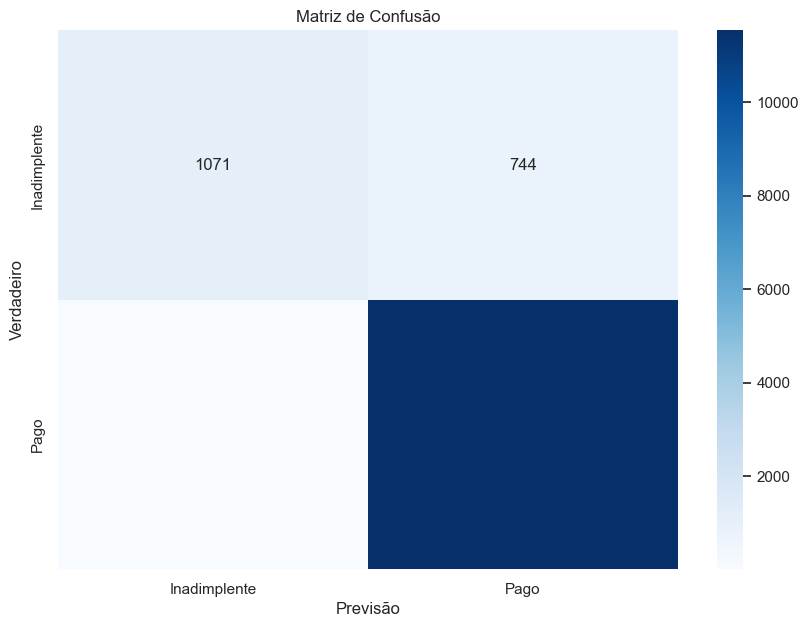

In [46]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Inadimplente', 'Pago'], yticklabels=['Inadimplente', 'Pago'])
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### Interpretação dos Resultados do Modelo

Os resultados fornecem uma visão geral do desempenho do modelo de classificação RandomForest no conjunto de testes. Vamos analisar cada métrica em detalhes:

#### 1. Acurácia de 94%

#### 2. Matriz de Confusão:
- Verdadeiros Negativos (TN): 1071
Número de empréstimos corretamente classificados como não pagos (inadimplentes).
- Falsos Positivos (FP): 744
Número de empréstimos incorretamente classificados como pagos, mas que na verdade não foram pagos.
- Falsos Negativos (FN): 4
Número de empréstimos incorretamente classificados como não pagos, mas que na verdade foram pagos.
- Verdadeiros Positivos (TP): 11544
Número de empréstimos corretamente classificados como pagos.

### 3. Classe Inadimplente (0):
Alta precisão, mas recall moderado, indicando que enquanto o modelo é bom em identificar empréstimos inadimplentes quando prevê inadimplência, ele perde uma quantidade significativa de empréstimos realmente inadimplentes.

### 4. Classe Pago (1):
Alta precisão e recall, mostrando que o modelo é eficaz em identificar empréstimos que serão pagos.
Implicações:


#### Resumindo, modelo é altamente eficaz em identificar empréstimos pagos, mas pode precisar de melhorias na identificação de inadimplentes para reduzir a quantidade de falsos negativos.

## Impacto Financeiro do Modelo

In [47]:
X_test['predicted_loan_status'] = y_pred


X_test['actual_loan_status'] = y_test.values


fully_paid_actual = X_test[X_test['actual_loan_status'] == 1]['total_pymnt'].sum()
charged_off_actual = X_test[X_test['actual_loan_status'] == 0]['total_pymnt'].sum()


fully_paid_predicted = X_test[X_test['predicted_loan_status'] == 1]['total_pymnt'].sum()
charged_off_predicted = X_test[X_test['predicted_loan_status'] == 0]['total_pymnt'].sum()

financial_impact = {
    'actual': {
        'fully_paid_total': fully_paid_actual,
        'charged_off_total': charged_off_actual
    },
    'predicted': {
        'fully_paid_total': fully_paid_predicted,
        'charged_off_total': charged_off_predicted
    }
}

financial_impact


{'actual': {'fully_paid_total': 169389408.22073787,
  'charged_off_total': 14059651.429967577},
 'predicted': {'fully_paid_total': 177768133.48070544,
  'charged_off_total': 5680926.170000001}}

### Interpretação dos Resultados do Impacto Financeiro

Os resultados fornecem uma comparação entre os valores totais de pagamento para empréstimos totalmente pagos e inadimplentes, tanto para os valores reais quanto para os valores previstos pelo modelo.

#### Impacto Financeiro Real (Actual)

- **Total de Pagamentos para Empréstimos Totalmente Pagos (Fully Paid Total)**:
  - Valor Real: \$169,389,408.22
  - Esse valor representa a soma total dos pagamentos recebidos de todos os empréstimos que foram totalmente pagos, conforme observado nos dados reais.

- **Total de Pagamentos para Empréstimos Inadimplentes (Charged Off Total)**:
  - Valor Real: \$14,059,651.43
  - Esse valor representa a soma total dos pagamentos recebidos de todos os empréstimos que foram inadimplentes, conforme observado nos dados reais.

#### Impacto Financeiro Previsto (Predicted)

- **Total de Pagamentos para Empréstimos Totalmente Pagos (Fully Paid Total)**:
  - Valor Previsto: \$177,768,133.48
  - Esse valor representa a soma total dos pagamentos previstos pelo modelo para todos os empréstimos que foram classificados como totalmente pagos.

- **Total de Pagamentos para Empréstimos Inadimplentes (Charged Off Total)**:
  - Valor Previsto: \$5,680,926.17
  - Esse valor representa a soma total dos pagamentos previstos pelo modelo para todos os empréstimos que foram classificados como inadimplentes.

### Comparação e Insights

#### 1. **Aumento nos Pagamentos de Empréstimos Totalmente Pagos**
   - **Valor Real**: \$169,389,408.22
   - **Valor Previsto**: \$177,768,133.48
   - **Diferença**: \$8,378,725.26 (Aumento)
   - O modelo prevê um aumento significativo nos pagamentos de empréstimos totalmente pagos, sugerindo que ele é eficaz em identificar empréstimos que têm uma alta probabilidade de serem pagos na íntegra.

#### 2. **Redução nos Pagamentos de Empréstimos Inadimplentes**
   - **Valor Real**: \$14,059,651.43
   - **Valor Previsto**: \$5,680,926.17
   - **Diferença**: \$8,378,725.26 (Redução)
   - O modelo prevê uma redução significativa nos pagamentos de empréstimos inadimplentes, sugerindo que ele é eficaz em identificar empréstimos que têm uma alta probabilidade de se tornarem inadimplentes.

### Implicações

- **Melhoria no Desempenho Financeiro**:
  - O modelo de previsão mostra um impacto financeiro positivo ao aumentar a quantidade total de pagamentos de empréstimos totalmente pagos e ao reduzir a quantidade total de pagamentos de empréstimos inadimplentes.

- **Eficiência do Modelo**:
  - A precisão do modelo em classificar corretamente empréstimos como totalmente pagos ou inadimplentes pode levar a uma estratégia de aprovação de empréstimos mais eficaz, resultando em maiores receitas e menores perdas.

### Resumo

- **Impacto Real**:
  - Empréstimos Totalmente Pagos: \$169,389,408.22
  - Empréstimos Inadimplentes: \$14,059,651.43

- **Impacto Previsto pelo Modelo**:
  - Empréstimos Totalmente Pagos: \$177,768,133.48
  - Empréstimos Inadimplentes: \$5,680,926.17

- **Diferença (Melhoria Financeira)**:
  - Aumento nos Pagamentos de Empréstimos Totalmente Pagos: \$8,378,725.26
  - Redução nos Pagamentos de Empréstimos Inadimplentes: \$8,378,725.26

Esses resultados indicam que o modelo pode proporcionar uma melhoria significativa no desempenho financeiro da carteira de empréstimos, aumentando os recebimentos e diminuindo as perdas.


# Implementação (futuros passos) 

In [ ]:
loan_data = pd.read_csv('loan_data_cleaned.csv')


loan_data.fillna(loan_data.mean(), inplace=True)
label_encoders = {}
for column in loan_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    loan_data[column] = le.fit_transform(loan_data[column])
    label_encoders[column] = le


X = loan_data.drop(columns=['loan_status'])
y = loan_data['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

In [ ]:
clf = joblib.load('loan_approval_model.pkl')
label_encoders = joblib.load('label_encoders.pkl')

def prepare_data(new_data):
    for column, le in label_encoders.items():
        new_data[column] = le.transform(new_data[column])
    return new_data

new_data = pd.DataFrame({
    'feature1': [value1],
    'feature2': [value2],
})

new_data_prepared = prepare_data(new_data)

predictions = clf.predict(new_data_prepared)
print("Previsão:", predictions)

### Monitoramento e Manutenção

Após implementar o modelo em produção, é importante monitorar seu desempenho e realizar manutenção periódica, incluindo:

- **Monitoramento Contínuo**: Acompanhar a acurácia e outras métricas de desempenho do modelo em produção.
- **Re-treinamento**: Re-treinar o modelo periodicamente com novos dados para garantir que ele permaneça preciso e relevante.
- **Ajustes**: Realizar ajustes no modelo conforme necessário, com base nos feedbacks e na análise dos resultados.
